<a href="https://colab.research.google.com/github/SiddheshDaphane/Deep_Learning_With_PyTorch/blob/master/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn # contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

### Data (preparing and loading)

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(50, 50)

### Split data into training and test sets

In [4]:
train_split = int(0.8 * len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

In [55]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

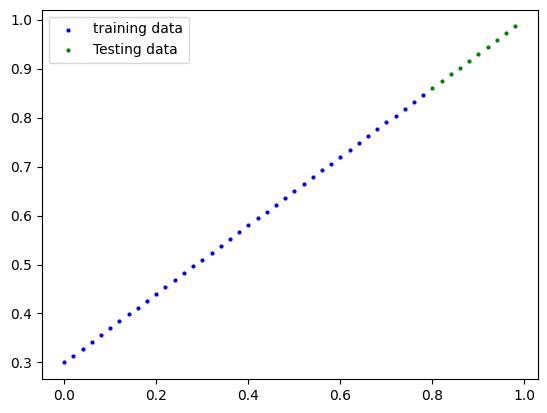

In [6]:
plt.scatter(X_train, y_train, c="b", s=4, label="training data")
plt.scatter(X_test, y_test, c="g", s=4, label = "Testing data")
plt.legend()
plt.show()

## Building a model

In [7]:
from torch import nn
import torch

In [8]:
# Create a Linear Regression model class

class LinearRegressionModel(nn.Module): # almost everything in PyTorch is a nn.Module meaning it is the base class
  def __init__(self):
    super().__init__() # Think of super().__init__() as a way to ensure your LinearRegressionModel gets all the capabilities of nn.Module.

    self.weights = nn.Parameter(torch.randn(1, requires_grad = True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad= True, dtype= torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias



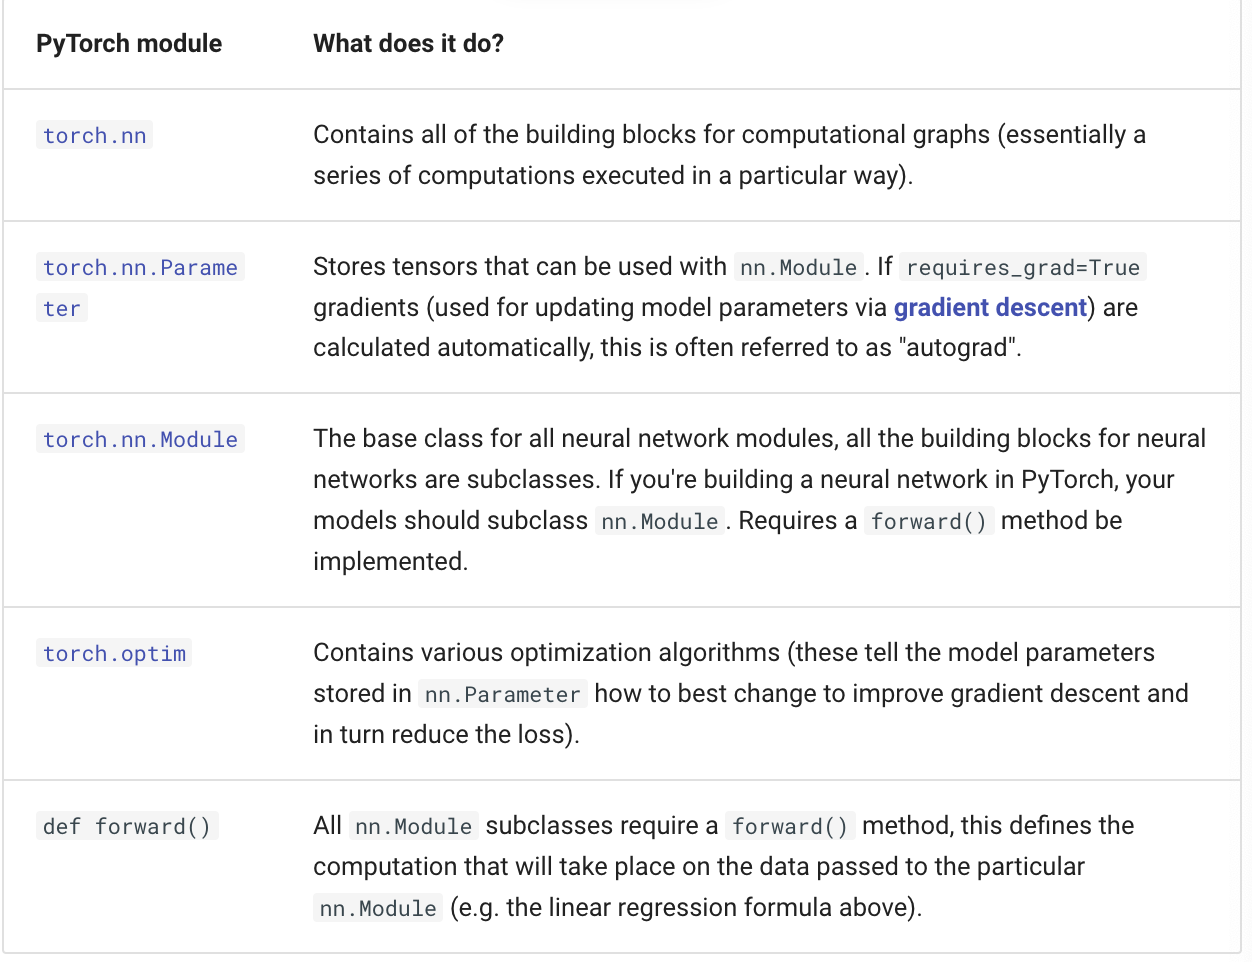

### Checking the contents of a PyTorch model

In [9]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that conatins nn.Parameter)
model_0 = LinearRegressionModel()

# Check the nn.parameters within nn.Module subclass we created
model_0.parameters()

<generator object Module.parameters at 0x7eca8b43b530>

In [10]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bounch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster

In [12]:
with torch.inference_mode():
  y_pred = model_0(X_test)

#### Plotting preditions

In [13]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label= "testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size":14})


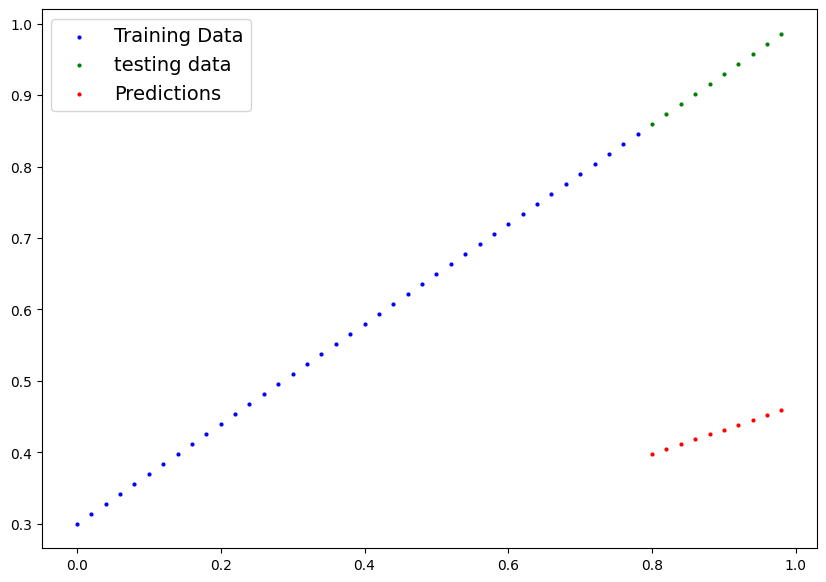

In [14]:
plot_predictions(predictions=y_pred)

## Train model

#### Creatingg a loss function and optimizer in PyTorch
For our model to upadate it's parameters on it'w own we need **Loss Fucntion** and **Optimizer**

* **Loss Function** :- Measures how wrong your model's predictions (e.g. `y_pred`) are compared to the truth labels (e.g. `y_test`). Lower the better

* **Optimizer** :- Tells your model how to update its internal parameters to best lower the loss

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01, 0.001, 0.0001`, however, these can also be adjusted over time (this is called learning rate scheduling).


In [15]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch
It's time to create a **training loop** (and **testing loop**)

The training loop involves the model going through the trainning data and learning the relationship between `features` and `labels`

The testing loop involves goimg through the testing data and evaluting how good the patterns are that the model learned on the training data (the model never see the testing data during training)

Each of these is called a "loop" beacuse we want our model to look (loop through) at each sample in each dataset

### PyTorch training loop

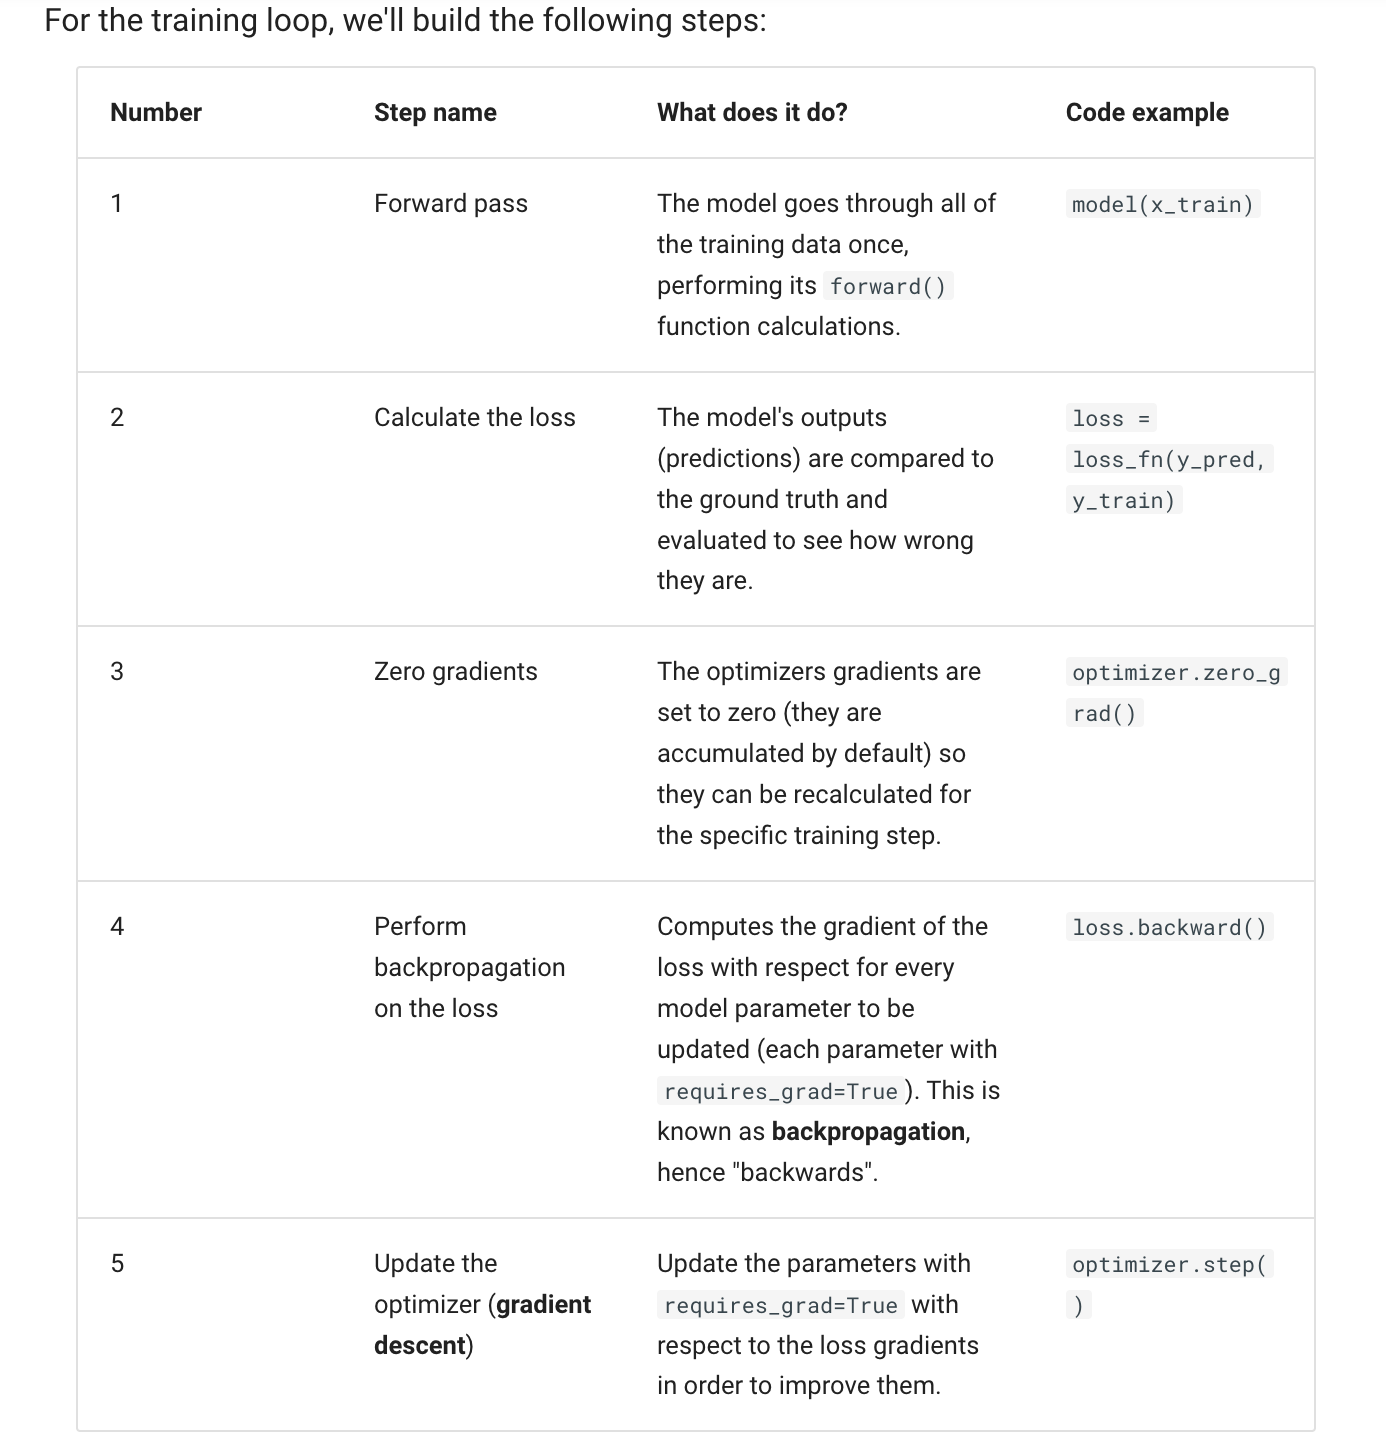

In [16]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  ### Training

  # Put model in training mode (this is default state of a model)
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss (how different are our models predictions to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### Testing

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass on test data
    test_pred = model_0(X_test)

    # 2. Caculate loss on test data
    test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")






Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss:

In [17]:
with torch.inference_mode():
  y_preds = model_0(X_test)

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

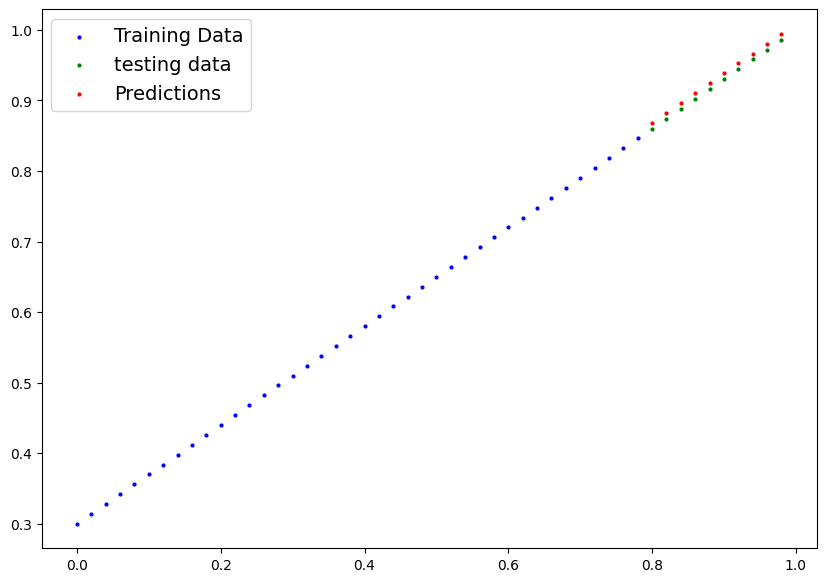

In [20]:
plot_predictions(predictions=y_preds)

In [21]:
import numpy as np
np.array(torch.tensor(train_loss_values).numpy()), test_loss_values

(array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
        0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
        0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

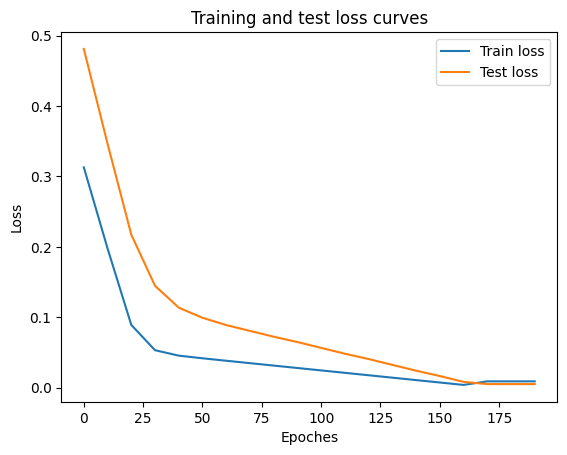

In [22]:


plt.plot(epoch_count,np.array(torch.tensor(train_loss_values).numpy()), label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoches")
plt.legend()
plt.show()


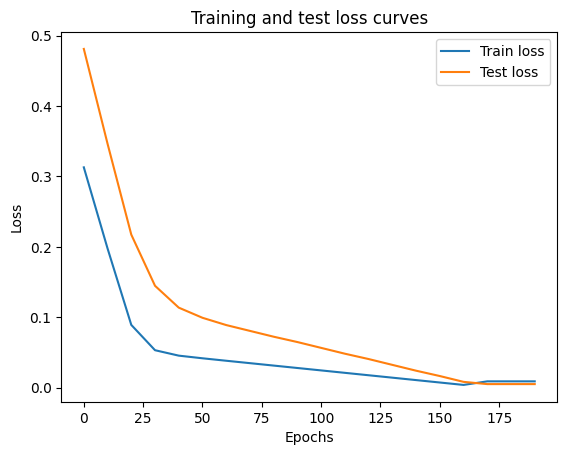

In [25]:
# Plot the loss curves
plt.plot(epoch_count, torch.tensor(train_loss_values).detach().numpy(), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Saving and loading a PyTorch model

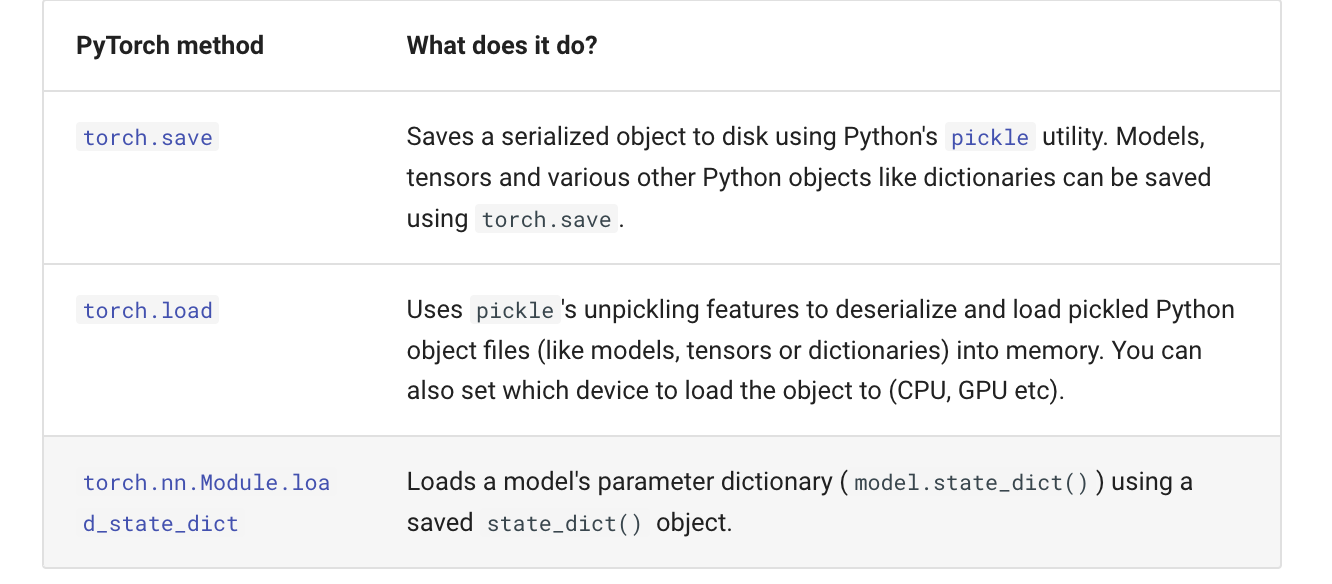

### Saving a pyTorch model's `state_dict()`

The recommended way for saving and loading a model for inference (makeing predictions) is by saving and loading a model's `state_dict()`

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module
2. We'll create a file path to save model to.
3. We'll call `torch.save(obj,f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

In [26]:
from pathlib import Path

# 1. Create models directory.
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only save the models learned parameters
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [28]:
# Check the saved file path
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Dec 20 13:54 01_pytorch_workflow_model_0.pth


## Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

* Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

* *Why not save the entire model?*

**The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...**

**Because of this, your code can break in various ways when used in other projects or after refactors.**



In [29]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-29-c3119fcaa06c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [30]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [32]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all togather
1) Import all packages and libraries.

2) Create some data (in real world, you will have the data).

3) Split the data into 80/20 split.

4) Then visualize the cerated data.

5) Build a PyTorch Linear Model

6) Train the model using training loop and eval the model using testing loop

7) Make predictions using trained model and comapre it with true values

8) Save and load a model

#### 6.1 Importing

In [36]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

Device-agnostic code means if we've got access to GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [40]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


#### 6.2 Data

In [41]:
# Create weights and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1) # without unsqueez, error will happen later on (shape within linear layers)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### 6.3 Split the data

In [43]:
# Split the data

train_split = int(0.7 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(35, 35, 15, 15)

#### 6.4 Visualize the data

In [44]:
# Plot the data.
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):

  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label = "Trainiing data")

  # plot testing data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

  # Plot predictiosn
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  # show the legends
  plt.legend(prop={"size": 12})

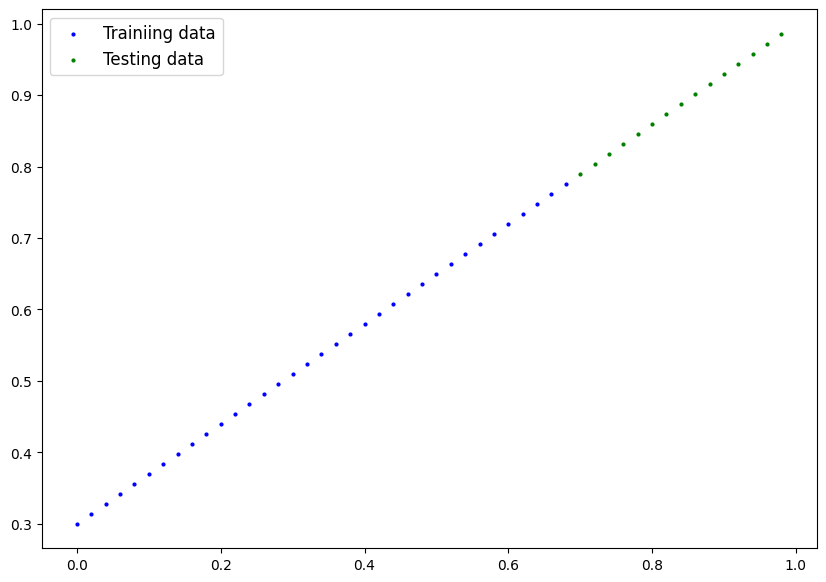

In [46]:
plot_predictions(X_train, y_train, X_test, y_test)

#### 6.5 Build a Model

In [53]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [54]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

#### 6.6 Training

In [55]:
# Create a loss function
loss_fn = nn.L1Loss()

# create optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [56]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [57]:
for epoch in range(epochs):

  ### Trainig
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_1.eval()

  # 1. Forward pass
  with torch.inference_mode():
    test_pred = model_1(X_test)

    # 2. Calcualte the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5519509315490723 | Test loss: 0.5713642239570618
Epoch: 100 | Train loss: 0.003985738847404718 | Test loss: 0.01037636213004589
Epoch: 200 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 300 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 400 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 500 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 600 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 700 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 800 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055
Epoch: 900 | Train loss: 0.003824308980256319 | Test loss: 0.012243409641087055


In [58]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6936]])),
             ('linear_layer.bias', tensor([0.3060]))])

#### 6.7 Making predictions

In [59]:
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.7915],
        [0.8054],
        [0.8193],
        [0.8331],
        [0.8470],
        [0.8609],
        [0.8747],
        [0.8886],
        [0.9025],
        [0.9164],
        [0.9302],
        [0.9441],
        [0.9580],
        [0.9718],
        [0.9857]])

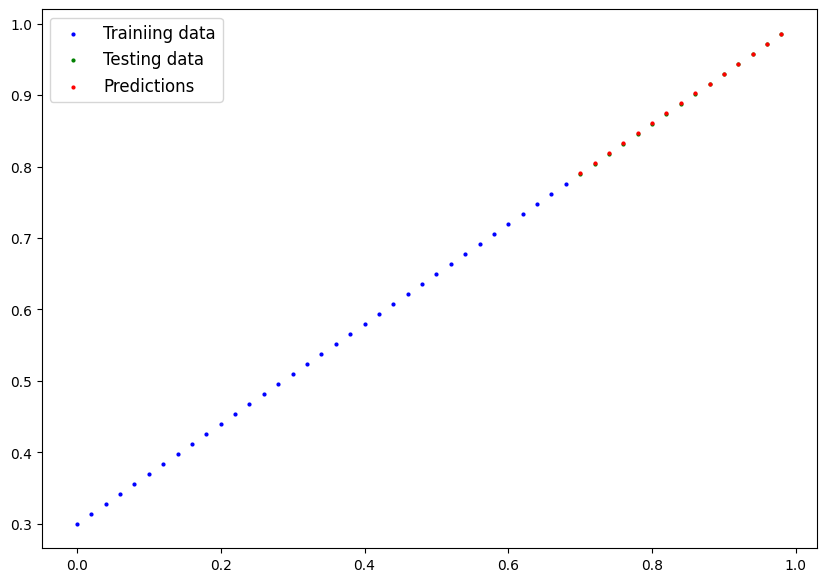

In [60]:
plot_predictions(predictions=y_preds)

#### 6.8 Saving and loading model

In [61]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [62]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


<ipython-input-62-c4e3cba863db>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [63]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Exercises

In [3]:
import datetime
print(f"Last updated: {datetime.datetime.now()}")

Last updated: 2024-12-21 13:31:50.338199


In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Create a straight line dataset using the linear regression formula `(weight * X + bias)`.

In [5]:
weight = 0.3
bias = 0.9

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")

Number of X samples: 50
Number of y samples: 50


In [7]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

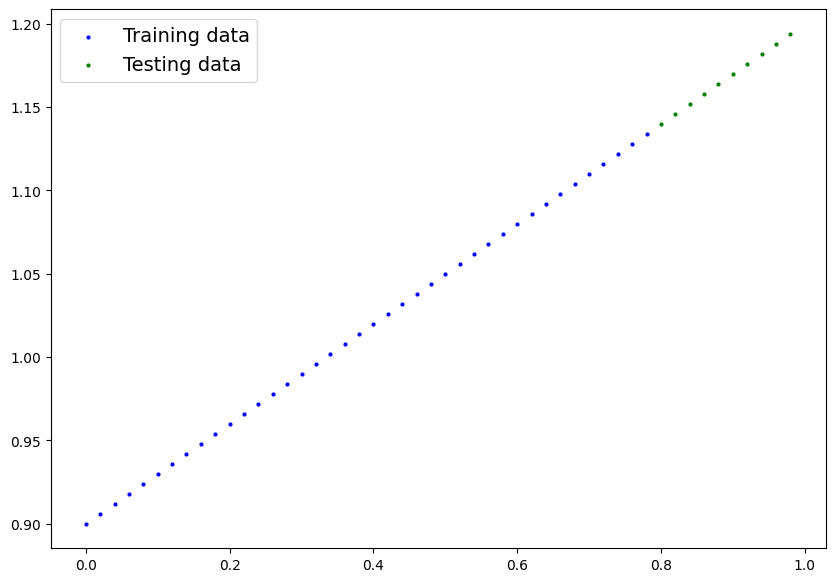

In [8]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_label, c='b', s=4, label="Training data")
  plt.scatter(test_data, test_label, c='g', s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="predictions")

  plt.legend(prop = {"size":14})

plot_predictions()


### 2. Build a PyTorch model by subclassing `nn.Module`.

In [12]:
class LinearRegressionModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [13]:
torch.manual_seed(42)
model_01 = LinearRegressionModel1()
model_01, model_01.state_dict()

(LinearRegressionModel1(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [14]:
next(model_01.parameters()).device

device(type='cpu')

In [15]:
model_01.to(device)
list(model_01.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

### 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.

In [17]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_01.parameters(),
                            lr = 0.01)

In [19]:
torch.manual_seed(42)

epochs = 300

# Send data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training loop

  # Put model in train mode
  model_01.train()

  # 1. Forward pass
  y_pred_train = model_01(X_train)

  # 2. Calculate Loss
  train_loss = loss_fn(y_pred_train, y_train)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Backpropogation
  train_loss.backward()

  # Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 20 == 0:
    # put model in eval mode
    model_01.eval()

    # inference mode on.
    with torch.inference_mode():
      # 1. Forward pass
      y_pred_test = model_01(X_test)

      # 2. Calculate loss
      test_loss = loss_fn(y_pred_test, y_test)

      # Print
      print(f"Epoch: {epoch} | Train Loss = {train_loss} | Test Loss = {test_loss}")

Epoch: 0 | Train Loss = 0.12616769969463348 | Test Loss = 0.33422544598579407
Epoch: 20 | Train Loss = 0.08189655840396881 | Test Loss = 0.21857480704784393
Epoch: 40 | Train Loss = 0.07218800485134125 | Test Loss = 0.17499032616615295
Epoch: 60 | Train Loss = 0.06520797312259674 | Test Loss = 0.15295077860355377
Epoch: 80 | Train Loss = 0.05831370875239372 | Test Loss = 0.1357191950082779
Epoch: 100 | Train Loss = 0.051440197974443436 | Test Loss = 0.11986131966114044
Epoch: 120 | Train Loss = 0.04457508772611618 | Test Loss = 0.10331656038761139
Epoch: 140 | Train Loss = 0.03770974278450012 | Test Loss = 0.08745871484279633
Epoch: 160 | Train Loss = 0.03083621896803379 | Test Loss = 0.07160083949565887
Epoch: 180 | Train Loss = 0.02396780252456665 | Test Loss = 0.055056132376194
Epoch: 200 | Train Loss = 0.01710296794772148 | Test Loss = 0.03919823095202446
Epoch: 220 | Train Loss = 0.010232259519398212 | Test Loss = 0.023340392857789993
Epoch: 240 | Train Loss = 0.003360512899234891

In [20]:
y_pred_test

tensor([[1.1365],
        [1.1426],
        [1.1486],
        [1.1547],
        [1.1607],
        [1.1668],
        [1.1728],
        [1.1789],
        [1.1849],
        [1.1910]])

### 4. Make predictions with the trained model on the test data.

In [21]:
# Make predictions
model_01.eval()

with torch.inference_mode():
  y_pred = model_01(X_test)

y_pred

tensor([[1.1496],
        [1.1558],
        [1.1619],
        [1.1680],
        [1.1742],
        [1.1803],
        [1.1864],
        [1.1925],
        [1.1987],
        [1.2048]])

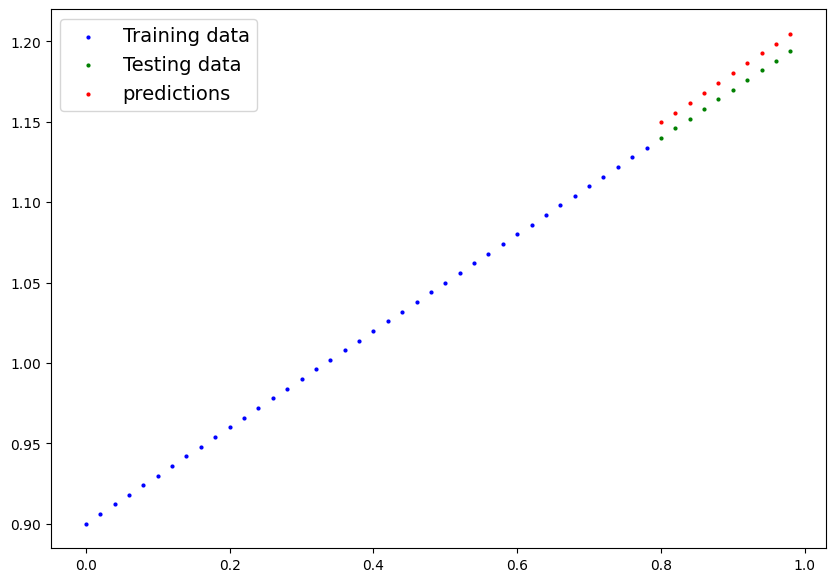

In [22]:
plot_predictions(predictions=y_pred)

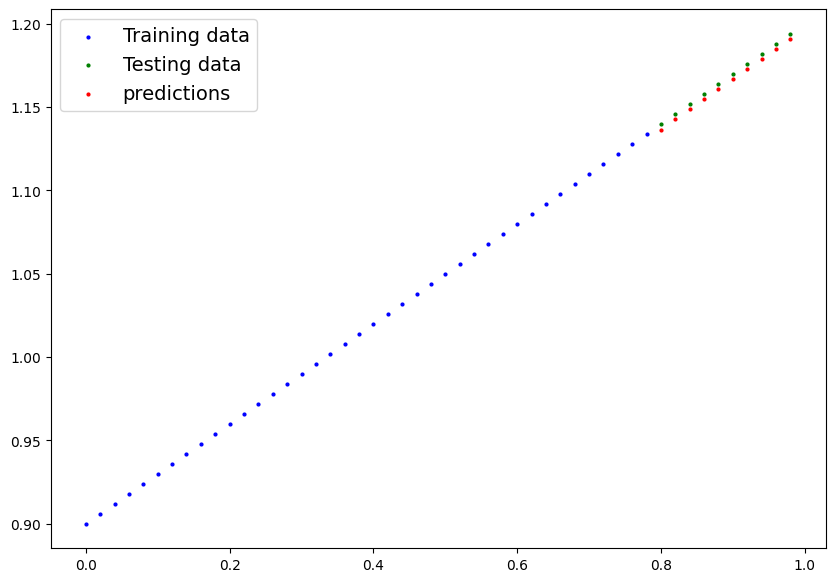

In [23]:
plot_predictions(predictions=y_pred_test)

### Save your trained model's `state_dict()` to file.

In [24]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_Linear_model"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj= model_01.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_Linear_model


In [30]:
# Create new instance of mmodel and load saved state dict
loaded_model = LinearRegressionModel1()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)

<ipython-input-30-1e8e39ea3c9c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


LinearRegressionModel1(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [31]:
# Make predictions
y_pred_new_01 = loaded_model(X_test)
y_pred == y_pred_new_01

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [32]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3064]])),
             ('linear_layer.bias', tensor([0.9045]))])